In [11]:
import pandas as pd
from openai import OpenAI
import os
import configparser
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage

### Notebook for testing LLM prompts, no results are logged here (either as csv or in Weights & Biases)

### Config Parameters

In [3]:
config = configparser.ConfigParser()
# Read the configuration file
config.read('config.ini')
api_key_openai = config.get('credentials', 'api_key_openai')
api_key_mistral = config.get('credentials', 'api_key_mistral')
surfdrive_url_input_sentences = config.get('credentials', 'surfdrive_url_input_sentences')
surfdrive_url_prompts = config.get('credentials', 'surfdrive_url_prompts')
output_chat_data_folder_path = 'output_llm_data/'

### Input & Prompts

In [9]:
# get a smaller subset of input sentences for these tests
neutral_sentences = pd.read_csv(surfdrive_url_input_sentences,sep=';')['sentences']
neutral_sentences = neutral_sentences[0:5]
neutral_sentences

0    I’m all about that food. I usually kick off th...
1    Just getting my vitamins in at the school cant...
2    De Pizzabakkers sell this vegan pizza with che...
3    I entered the world of vegan foods lately. Nex...
4    This vegan fried chicken from KFC is on the sp...
Name: sentences, dtype: object

In [6]:
df_prompts = pd.read_csv(surfdrive_url_prompts,sep=';').reset_index()
df_prompts

,index,promptID,promptContent
0,0,0,Here is some text {}. Here is a rewrite of the...


### Prompt making

In [7]:
# getting the relevant prompts
prompt_content = df_prompts['promptContent'][0]
prompt_id = str(df_prompts['promptID'][0])

### Single Model Runs

In [10]:
# "mistral-tiny", "mistral-small", "mistral-medium"
mistral_m = "mistral-tiny"
mistral_client = MistralClient(api_key = api_key_mistral)

print("run-" + "promptID_" + prompt_id + '_model_'+ mistral_m)

final_output = []

for i in range(0,len(neutral_sentences)-1):   
    original = neutral_sentences[i]
    query = f"{prompt_content.replace('{}', f'{{{original}}}')}"
    
    messages = [ ChatMessage(role = "user", content = query) ]
    
    # No streaming
    chat_response = mistral_client.chat(
        model = mistral_m,
        messages = messages,
    )
    
    final_output.append({'original': original,'output': chat_response.choices[0].message.content,"model": chat_response.model, "prompt_tokens" : chat_response.usage.prompt_tokens,"completion_tokens" : chat_response.usage.completion_tokens,"object" : chat_response.object, "promptID" : prompt_id})

df_mistral_output = pd.DataFrame(final_output)
df_mistral_output

run-promptID_0_model_mistral-tiny


,original,output,model,prompt_tokens,completion_tokens,object,promptID
0,I’m all about that food. I usually kick off th...,I'm excited about today's delicious meal! I al...,mistral-tiny,63,42,chat.completion,0
1,Just getting my vitamins in at the school cant...,Preparing for my math exam with a nutritious a...,mistral-tiny,67,57,chat.completion,0
2,De Pizzabakkers sell this vegan pizza with che...,The Pizzabakkers offer a delicious vegan pizza...,mistral-tiny,65,36,chat.completion,0
3,I entered the world of vegan foods lately. Nex...,I'm excited to explore the world of vegan food...,mistral-tiny,63,58,chat.completion,0


In [11]:
# GPT pre-setup
gtp_client = OpenAI(api_key = api_key_openai)
# "gpt-3.5-turbo", "gpt-4"
gpt_m = "gpt-3.5-turbo"
gpt_system_msg = "You are an expert in text style transfer."
gpt_temperature = 0.2
gpt_max_tokens = 256
gpt_frequency_penalty = 0.0

print("run-" + "promptID_" + prompt_id + '_model_'+ gpt_m)
final_output = []
for i in range(0,len(neutral_sentences)-1):          
    original = neutral_sentences[i]
    query = f"{prompt_content.replace('{}', f'{{{original}}}')}"
    
    message=[{"role": "system", "content": gpt_system_msg}, {"role": "user", "content":query}]
    
    chat_response = gtp_client.chat.completions.create(
        model = gpt_m,
        messages = message,
        temperature = gpt_temperature,
        max_tokens = gpt_max_tokens,
        frequency_penalty = gpt_frequency_penalty
    )
    final_output.append({'original': original,'output': chat_response.choices[0].message.content,"model": chat_response.model, "prompt_tokens" : chat_response.usage.prompt_tokens,"completion_tokens" : chat_response.usage.completion_tokens,"object" : chat_response.object, "promptID" : prompt_id, "temperature": gpt_temperature})
    
df_gpt_output = pd.DataFrame(final_output)
df_gpt_output

run-promptID_0_model_gpt-3.5-turbo


,original,output,model,prompt_tokens,completion_tokens,object,promptID,temperature
0,I’m all about that food. I usually kick off th...,"I absolutely adore food! Every week, I start m...",gpt-3.5-turbo-0613,71,38,chat.completion,0,0.2
1,Just getting my vitamins in at the school cant...,Just fueling up on nutrients at the school can...,gpt-3.5-turbo-0613,76,49,chat.completion,0,0.2
2,De Pizzabakkers sell this vegan pizza with che...,De Pizzabakkers offer an incredible vegan pizz...,gpt-3.5-turbo-0613,73,36,chat.completion,0,0.2
3,I entered the world of vegan foods lately. Nex...,I've recently embraced the world of vegan food...,gpt-3.5-turbo-0613,72,57,chat.completion,0,0.2


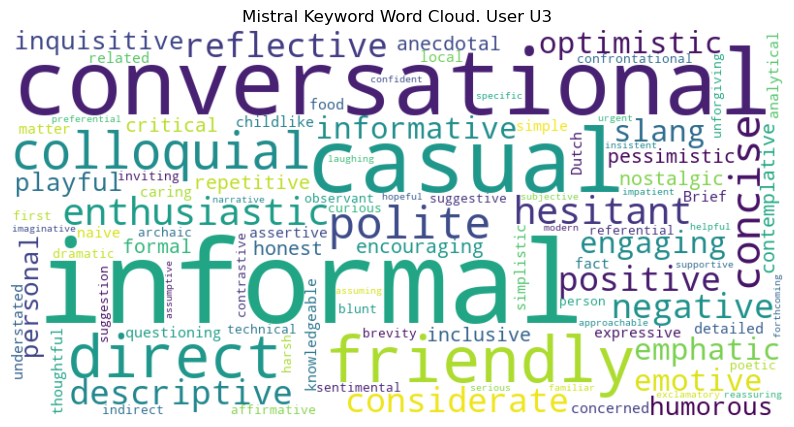

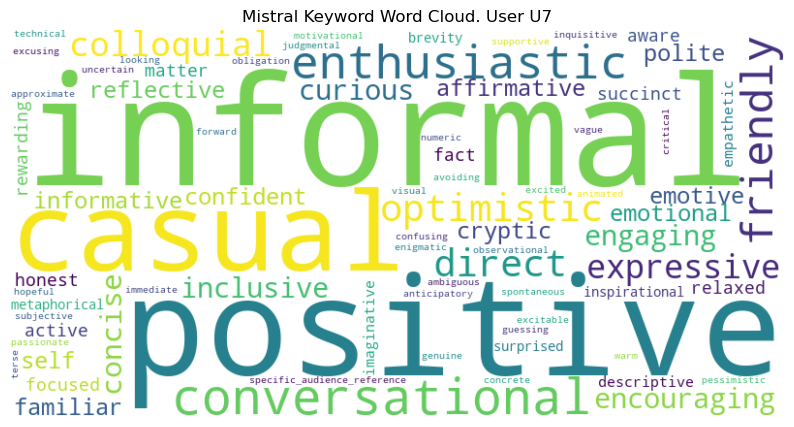

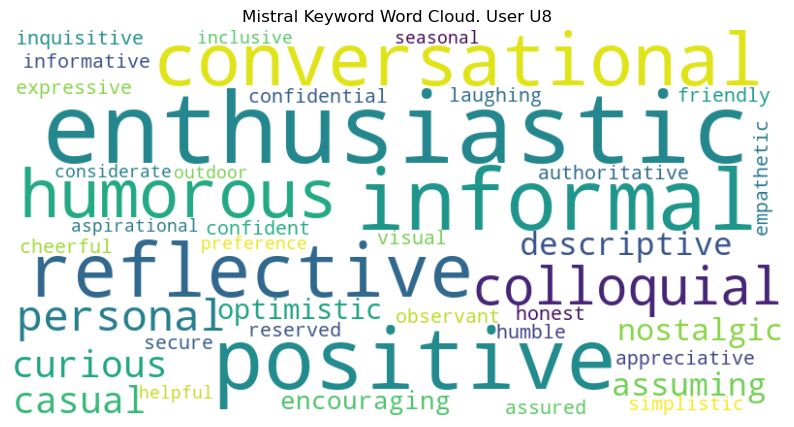

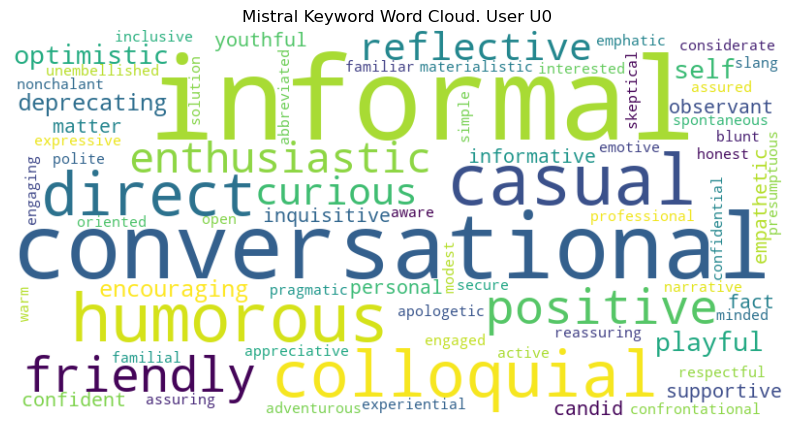

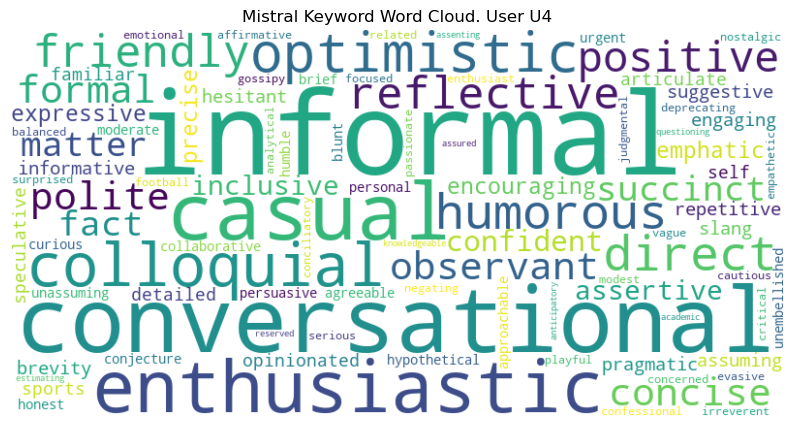

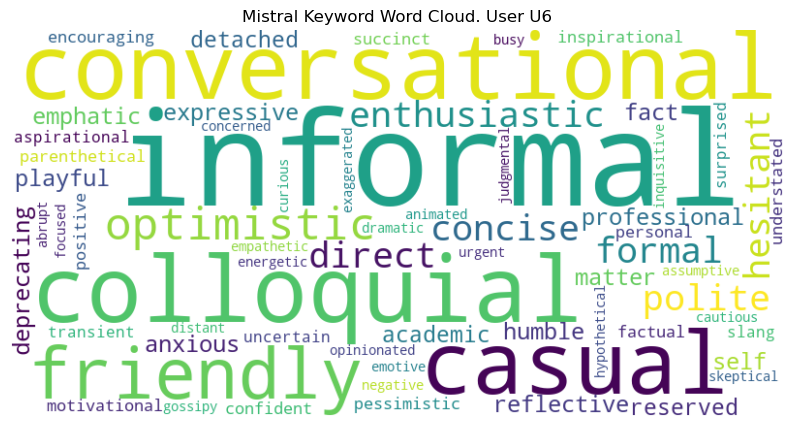

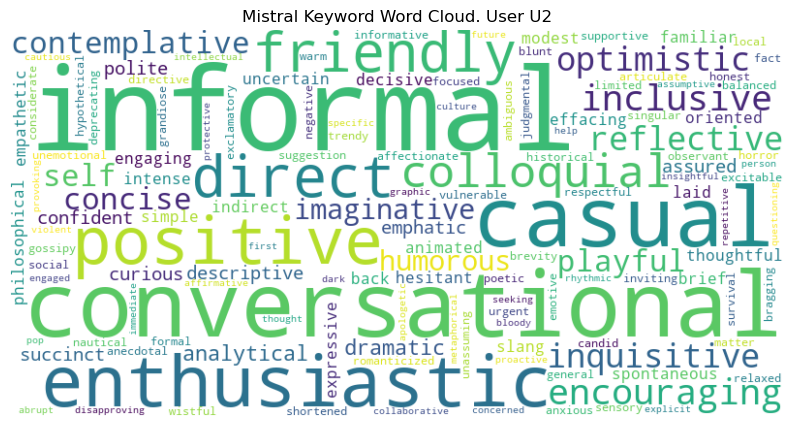

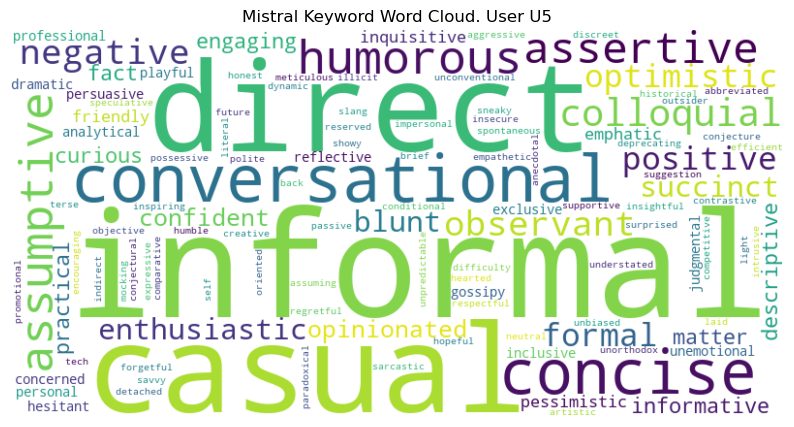

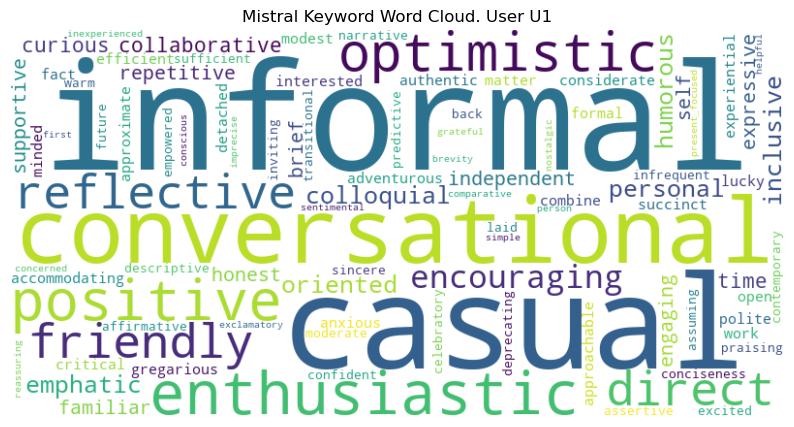

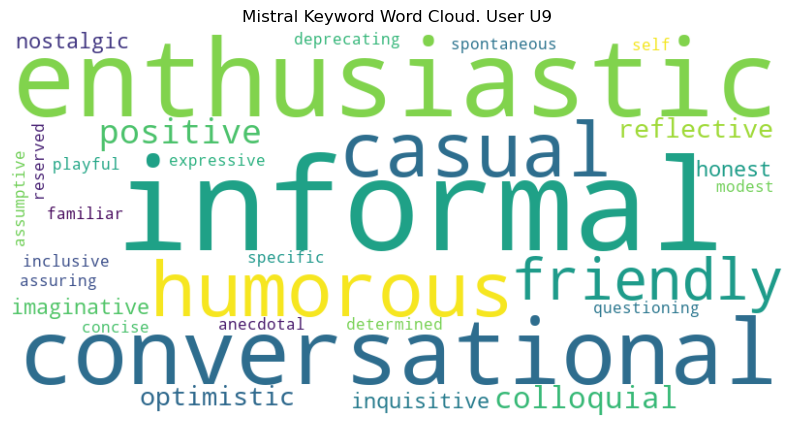

In [58]:
from wordcloud import WordCloud
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import glob

parallel_folder = 'output_parallel_data/'

csv_files = glob.glob('*')
usernames= []
median_word_count_list = []
num_sentences = []


for file in csv_files:
    print(file)
    # Check if the file ends with 'chat_llm.csv'
    if file.endswith('parallel_data_mistral_medium.csv'):
        
        username = file[0:2]
        print(file)
        df_test = pd.read_csv(file)
    
        keywords_lists = [ast.literal_eval(keyword_str) for keyword_str in list(df_test['style_keywords'])]
        # Merge all lists into one
        all_keywords = [keyword for sublist in keywords_lists for keyword in sublist]
        # Create a DataFrame with keyword and frequency columns
        keywords_df = pd.DataFrame({'keyword': all_keywords})
        # Count the frequency of each keyword
        keyword_counts = keywords_df['keyword'].value_counts().reset_index()
        # Rename the columns
        keyword_counts.columns = ['keyword', 'frequency']
        
        # Add a 'percentage' column
        total_keywords = keyword_counts['frequency'].sum()
        keyword_counts['percentage'] = (keyword_counts['frequency'] / total_keywords) * 100
        
        # Sort the DataFrame by frequency in descending order
        keyword_counts = keyword_counts.sort_values(by='frequency', ascending=False)
        # Display the final DataFrame
        keyword_counts.to_csv(parallel_folder + username + '_mistral_keywords_details.csv')
        
        # Create a WordCloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_keywords))
        
        # Plot the WordCloud
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Mistral Keyword Word Cloud. User ' + username)
        
        
        # Save the WordCloud image to a PNG file
        plt.savefig(parallel_folder + username + '_mistral_keyword_cloud_image.png', bbox_inches='tight')


In [21]:
len(all_keywords)

285

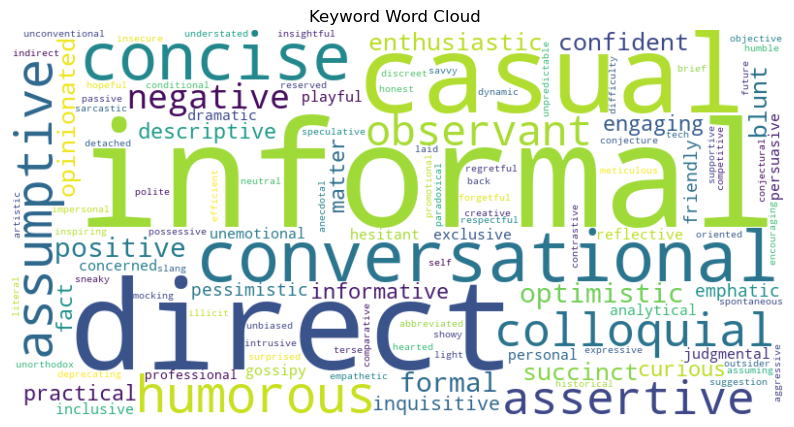

/var/folders/t4/v59wrn6n2ws6kl1t9zh1q_mc0000gn/T/ipykernel_2011/2837346791.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='keyword', data=keyword_counts.head(10), palette='viridis',errorbar=None, capsize=0.2, errwidth=1.5, dodge=False)
/var/folders/t4/v59wrn6n2ws6kl1t9zh1q_mc0000gn/T/ipykernel_2011/2837346791.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(x='frequency', y='keyword', data=keyword_counts.head(10), palette='viridis',errorbar=None, capsize=0.2, errwidth=1.5, dodge=False)


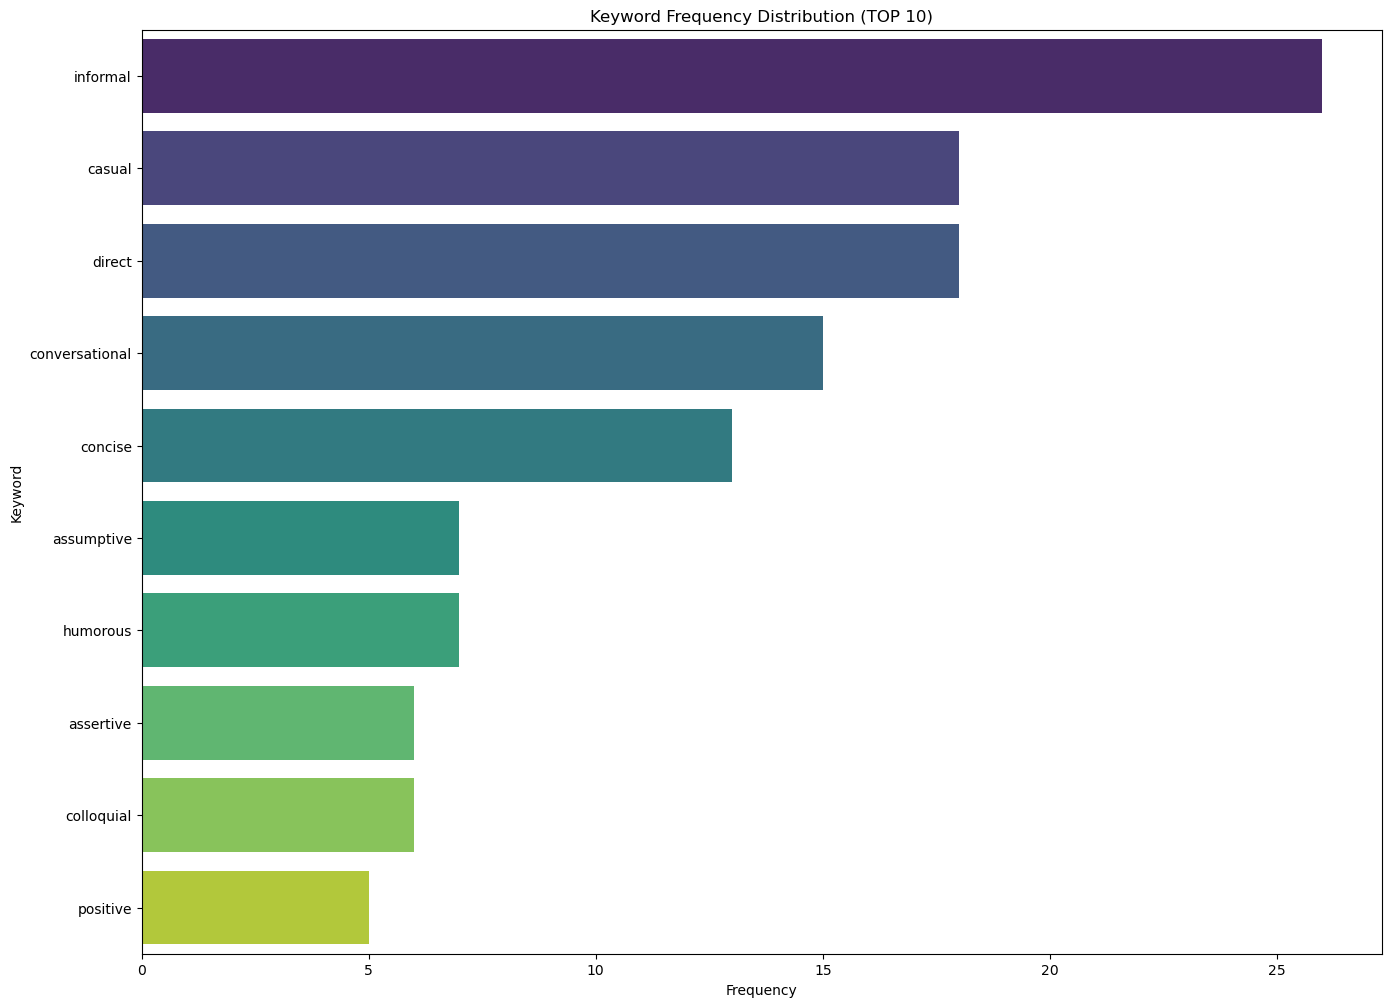

In [35]:
import seaborn as sns

# Plotting using Seaborn
plt.figure(figsize=(16, 12))
sns.barplot(x='frequency', y='keyword', data=keyword_counts.head(10), palette='viridis',errorbar=None, capsize=0.2, errwidth=1.5, dodge=False)
plt.title('Keyword Frequency Distribution (TOP 10)')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.show()